In [2]:
import pandas as pd
from dateparser.search import search_dates
import seaborn as sns
import glob
dataf = 'SDcountySituation-{}.csv'
tab_hist = {}

In [58]:
# Don't run this anymore!! We only needed it once.
# I used wayback machine to collect the county data for the dates before I began this project, starting with first day over 100 cases
# for some reason the wayaback and the current web scrape produce different numbers of tables
'''get_historical_data = [
    'https://web.archive.org/web/20200320184055/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200321141257/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200322080211/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200323094801/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html',
    'https://web.archive.org/web/20200324003021/https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html'
]

for link in get_historical_data:
    tab = pd.read_html(link)
    #comes down as a list of each column seperately, with the header the same in each column-table
    table = tab[2].drop(0)
    # setup header and index
    cs =  table.iloc[0,:].to_list()
    cs[0] = 'index'
    table.columns = cs
    table = table.drop(1).set_index('index')
    # get todays date from that header we threw away on each column
    dt = search_dates(tab[2].iloc[0,0])[-1][1]
    today = dt.strftime('%Y-%m-%d')
    # theres some variability in nomenclature to deal with from day to day
    idx = table.index.to_series()
    idx[ 'Hospitalized' == idx ] = 'Hospitalizations'
    table.index = idx
    if not 'Intensive Care' in idx:
        table.loc['Intensive Care',:] = 0
        
    print(today)
    # record todays data for posterity
    table.to_csv(dataf.format(today))
    tab_hist[today] = table
    '''

2020-03-19
2020-03-20
2020-03-21
2020-03-22
2020-03-23


In [126]:
# From now on we can just load the data that's already in the repo
files = glob.glob('*.csv') # gets all .csv filenames in directory
for afile in files:
    dt = afile[18:28]
    print(dt)
    tab_hist[dt] = pd.read_csv(afile,index_col=0,header=0)

2020-03-22
2020-03-23
2020-03-21
2020-03-20
2020-03-24
2020-03-19


In [3]:
# Run me every day! Website updates once a day at around 4pm
tab = pd.read_html('https://www.sandiegocounty.gov/content/sdc/hhsa/programs/phs/community_epidemiology/dc/2019-nCoV/status.html')
#comes down as a list of each column seperately, with the header the same in each column-table
tabs = [ x.drop(0) for x in tab]
table = pd.concat(tabs)
# setup header and index
cs =  table.iloc[0,:].to_list()
cs[0] = 'index'
table.columns = cs
table = table.drop(1).set_index('index')
# get todays date from that header we threw away on each column
dt = search_dates(tab[0][0][0])[-1][1]
today = dt.strftime('%Y-%m-%d')
# record todays data for posterity
table.to_csv(dataf.format(today))
tab_hist[today] = table

table

,San Diego County Residents,Non-San Diego County Residents,Total
index,,,
Total Positives,226,16,242
Age Groups,NaN,NaN,NaN
0-9 years,2,0,2
10-19 years,2,1,3
20-29 years,46,8,54
30-39 years,63,3,66
40-49 years,41,2,43
50-59 years,33,0,33
60-69 years,17,1,18


In [59]:
cases = pd.Series({key:int(value.loc['Total Positives','Total']) for key,value in tab_hist.items()}).sort_index()
hospitalizations = pd.Series({key:int(value.loc['Hospitalizations','Total']) for key,value in tab_hist.items()}).sort_index()
icu = pd.Series({key:int(value.loc['Intensive Care','Total']) for key,value in tab_hist.items()}).sort_index()
deaths = pd.Series({key:int(value.loc['Deaths','Total']) for key,value in tab_hist.items()}).sort_index()

In [111]:
sns.set_style('darkgrid')
colors = sns.color_palette()
import matplotlib.pyplot as plt

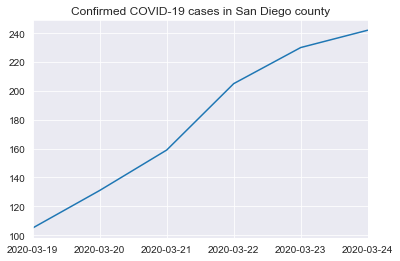

In [104]:
cases.plot(title='Confirmed COVID-19 cases in San Diego county',color=colors[0]);

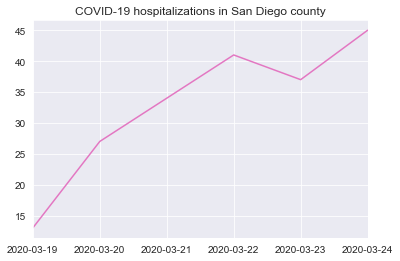

In [110]:
hospitalizations.plot(title='COVID-19 hospitalizations in San Diego county', color=colors[6]);

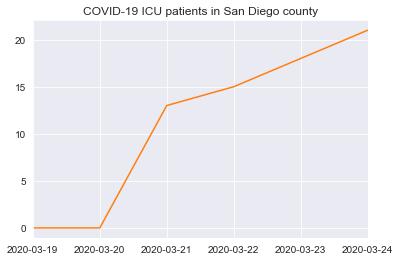

In [106]:
icu.plot(title='COVID-19 ICU patients in San Diego county', color=colors[1]);

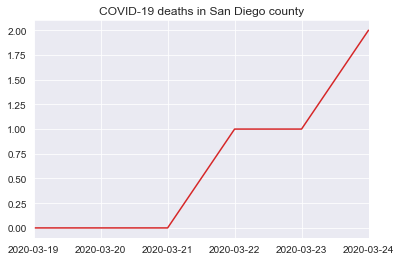

In [107]:
deaths.plot(title='COVID-19 deaths in San Diego county', color=colors[3]);